In [1]:
import xarray as xr
from cmocean import cm as cmo 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import glidertools as gt

%matplotlib inline

## Load case study glider mission and bathymetry

In [2]:
ds = xr.open_dataset('../data/Gliders/Glider_vert_gridded_spice13.nc')
ds = ds.where((ds.dive_lat<-32.5) & (ds.dive_lat>-34),drop=True)
bath = xr.open_dataset('../data/subset_ETOPO1_Ice_g_gmt4.grd')

In [12]:
# distance hasn't worked with this file for some reason, but we can add it manually
ds['distance'] = (gt.utils.distance(ds.x, ds.y)/1000).cumsum()

### load altimetry and ocean colour

In [4]:
ocl = xr.open_dataset('../data/IMOS_ocl_2015_04_25.nc')
alt = xr.open_dataset('../data/IMOS_aggregation_20221013T100823Z.nc')

## Define map plotting functions

In [5]:
def plot_saltmin(ds,ax):
    saltmin = ds.PSAL_vert_binned.min(dim="PRES")
    saltthresh = saltmin.where(saltmin<35.24,drop=True)
    ax.set_extent([150.5, 153.1, -34.5, -32.5], crs=ccrs.PlateCarree())
    cs=bath.z.plot.contour(levels=[-100, -200, -1000, -2000],colors='k',transform=ccrs.PlateCarree())
    cs.clabel(fontsize=12, inline=1)
    # Gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.MaxNLocator(6)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    #add coast
    ax.add_feature(cfeature.GSHHSFeature('i', edgecolor='black', facecolor='lightgrey'))
    
    plt.scatter(saltthresh.x,saltthresh.y,marker = 'o',color='red', s=10)
    im = plt.scatter(saltmin.x,saltmin.y,c=saltmin,s=3,vmin=33,vmax=35.5)
    cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.45, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
    cbar = fig.colorbar(im, cax=cax) 
    cbar.set_label('Salinity [psu]')

In [6]:
def plot_cdommax(ds,ax):
    cdommax = ds.CDOM_vert_binned.max(dim="PRES")
    ax.set_extent([150.5, 153.1, -34.5, -32.5], crs=ccrs.PlateCarree())
    cs=bath.z.plot.contour(levels=[-100, -200, -1000, -2000],colors='k',transform=ccrs.PlateCarree())
    cs.clabel(fontsize=12, inline=1)
    # Gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.MaxNLocator(6)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.add_feature(cfeature.GSHHSFeature('i', edgecolor='black', facecolor='lightgrey'))


    
    #plot PH100 position
    plt.plot(151.2252666667,-34.1192,'o', color='black',markersize=8)
    
    im = plt.scatter(cdommax.x,cdommax.y,c=cdommax,s=10,cmap=cmo.turbid,transform=ccrs.PlateCarree(),vmin=0,vmax=2)
    cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.45, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
    cbar = fig.colorbar(im, cax=cax) 
    cbar.set_label('CDOM [m $^{-1}$]')

In [7]:
def plot_ocl(ds,ax,day,glid,sect):
    ax.set_extent([150.5, 153.1, -34.5, -32.5], crs=ccrs.PlateCarree())
    cs=bath.z.plot.contour(levels=[-100, -200, -1000, -2000],colors='k',transform=ccrs.PlateCarree())
    cs.clabel(fontsize=12, inline=1)
    im=ocl.chl_oc3.plot(cmap=cmo.algae,add_colorbar=False,vmin=0,vmax=2)
    Q = plt.quiver(alt.LONGITUDE, alt.LATITUDE, alt.UCUR.sel(TIME=day).squeeze()
                   , alt.VCUR.sel(TIME=day).squeeze(), units='width', scale=15,zorder=1e35)
    plt.quiverkey(Q, X=150.75, Y=-33.75, U=1, color='black',coordinates='data',
                 label='1 m s$^{-1}$', labelpos='S',zorder=10)
    # Gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.MaxNLocator(6)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.add_feature(cfeature.GSHHSFeature('i', edgecolor='black', facecolor='lightgrey'))
  
    #plot PH100 position
    plt.plot(151.2252666667,-34.1192,'o', color='black',markersize=8)
    plt.scatter(glid.x,glid.y,s=10,c='tab:blue',transform=ccrs.PlateCarree())
    plt.scatter(sect.x,sect.y,s=10,c='tab:orange',transform=ccrs.PlateCarree())
#     im = plt.scatter(cdommax.x,cdommax.y,c=cdommax,s=10,cmap=cmo.turbid,transform=ccrs.PlateCarree(),vmin=0,vmax=2)
    cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.45, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
    cbar = fig.colorbar(im, cax=cax) 
    cbar.set_label('Chla [mg m$^{-3}$]')

## function to reference glider dataset by distance instead of profile

In [13]:
def make_distance_dataset(ds):
    # create data
    salt = ds.PSAL_vert_binned.data
    temp = ds.TEMP_vert_binned.data
    cdom = ds.CDOM_vert_binned.data
    dens = ds.potential_density_vert_binned.data
    brun = ds.BRUNTV_vert_binned.data
    time = ds.dive_time.data
    # create coords
    DIST = (ds.distance-ds.distance[0]).data
    PRES = ds.PRES.data

    # put data into a dataset
    nc = xr.Dataset(
        data_vars=dict(
            salt=(["PRES", "DIST"], salt),
            temp=(["PRES", "DIST"], temp),
            cdom=(["PRES", "DIST"], cdom),
            dens=(["PRES", "DIST"], dens),
            brun=(["PRES", "DIST"], brun),
            time=(["DIST"],time),
        ),
        coords=dict(
            PRES=(["PRES"], PRES),
            DIST=(["DIST"], DIST),
        ),
        attrs=dict(description="test "+str(ds)),
    )

    return nc

### Make distance dataset, separate out section of interest from both distance and profile referenced datasets

In [14]:
nc = make_distance_dataset(ds)
sect=nc.sel(DIST=slice(120, 210))
sect['DIST']=sect.DIST-sect.DIST[0]
sect15=ds.sel(PROFILE=slice(1500, 1800))

/Users/neilmalan/miniconda3/envs/Ncomms2023/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/neilmalan/miniconda3/envs/Ncomms2023/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/neilmalan/miniconda3/envs/Ncomms2023/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/neilmalan/miniconda3/envs/Ncomms2023/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecate

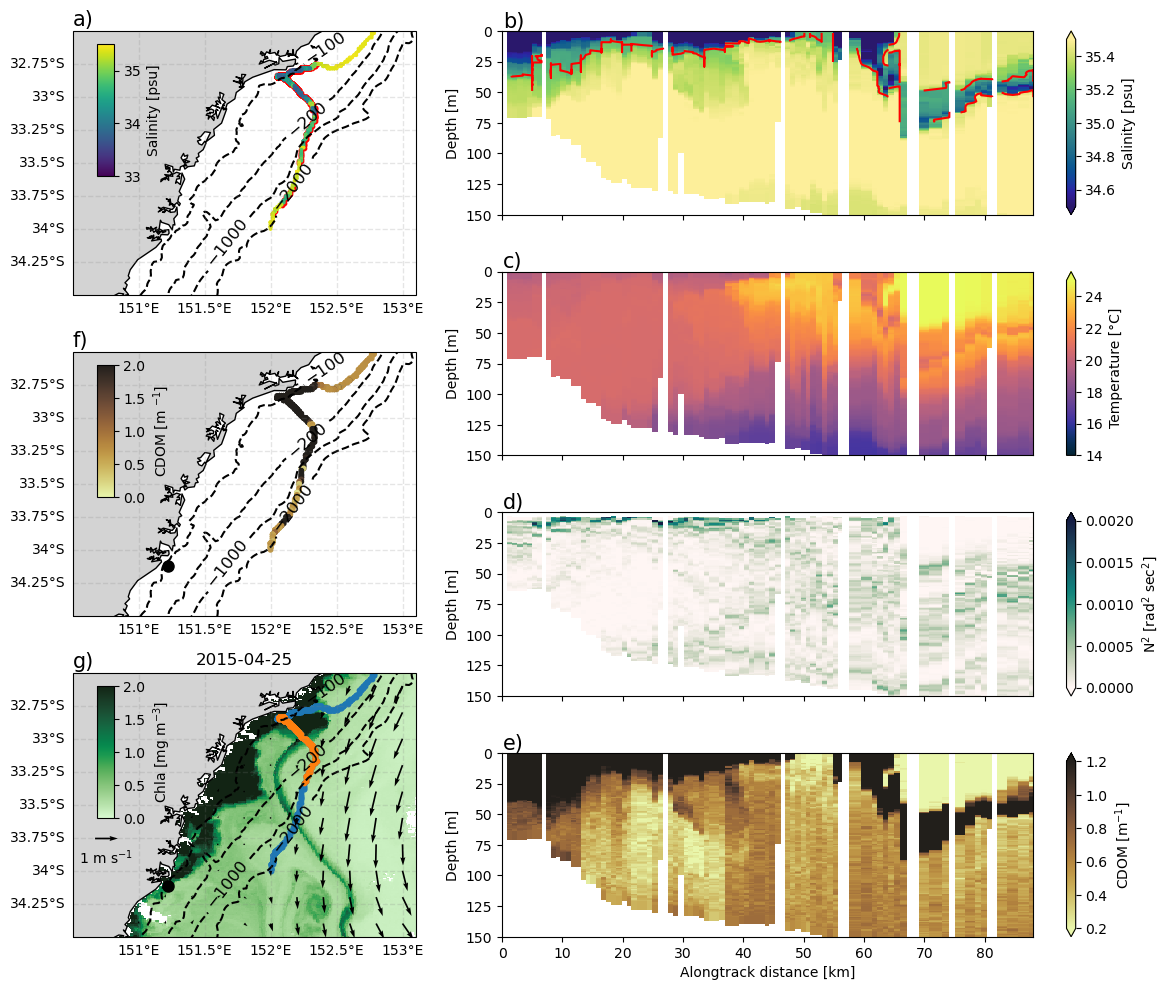

In [ ]:
mosaic = """
    AAABBBBB
    AAABBBBB
    AAABBBBB
    AAACCCCC
    FFFCCCCC
    FFFCCCCC
    FFFDDDDD
    FFFDDDDD
    GGGDDDDD
    GGGEEEEE
    GGGEEEEE
    GGGEEEEE
    """
fig = plt.figure(figsize=(12,10))
ax = fig.subplot_mosaic(mosaic)
# trick to add cartopy axes (https://github.com/matplotlib/matplotlib/issues/20392)
ss = ax['A'].get_subplotspec()
ax['A'].remove()
ax['A'] = fig.add_subplot(ss, projection=ccrs.PlateCarree())
plot_saltmin(ds,ax['A'])
ax['A'].text(.001, 1.02, 'a)',transform=ax['A'].transAxes, fontsize=15)

sect.salt.plot(cmap=cmo.haline
                       ,ax=ax['B']
                       ,vmin=34.5
                       ,vmax=35.5
                       ,ylim=(0,150)
                       ,cbar_kwargs={'label': 'Salinity [psu]'})
# highlight low salinity contour
sect.salt.where(ds.PRES<75).plot.contour(levels=[35.163],colors='red',ax=ax['B'])
ax['B'].set_xlabel('')
ax['B'].set_xticklabels('');
ax['B'].text(.001, 1.02, 'b)',transform=ax['B'].transAxes, fontsize=15)

sect.temp.plot(cmap=cmo.thermal
                       ,ax=ax['C']
                       ,vmin=14
                       ,vmax=25
                       ,ylim=(0,150)
                       ,cbar_kwargs={'label': 'Temperature [°C]'})

ax['C'].set_xlabel('')
ax['C'].set_xticklabels('');
ax['C'].text(.001, 1.02, 'c)',transform=ax['C'].transAxes, fontsize=15)

sect.brun.plot(cmap=cmo.tempo
                       ,ax=ax['D']
                       ,vmin=0
                       ,vmax=0.002
                       ,ylim=(0,150)
                       ,cbar_kwargs={'label': 'N$^2$ [rad$^{2}$ sec$^{2}$]'})
ax['D'].set_xlabel('')
ax['D'].set_xticklabels('');
ax['D'].set_xlabel('')
ax['D'].set_xticklabels('');
ax['D'].text(.001, 1.02, 'd)',transform=ax['D'].transAxes, fontsize=15)

sect.cdom.plot(cmap=cmo.turbid
                       ,ax=ax['E']
                       ,vmin=.2
                       ,vmax=1.2
                       ,ylim=(0,150)
                       ,cbar_kwargs={'label': 'CDOM [m$^{-1}$]'})
ax['E'].text(.001, 1.02, 'e)',transform=ax['E'].transAxes, fontsize=15)


ss = ax['F'].get_subplotspec()
ax['F'].remove()
ax['F'] = fig.add_subplot(ss, projection=ccrs.PlateCarree())
plot_cdommax(ds,ax['F'])
ax['F'].text(.001, 1.02, 'f)',transform=ax['F'].transAxes, fontsize=15)

ss = ax['G'].get_subplotspec()
ax['G'].remove()
ax['G'] = fig.add_subplot(ss, projection=ccrs.PlateCarree())
day='2015-04-25'
plot_ocl(ds,ax['G'],day,ds,sect15)
ax['G'].text(.001, 1.02, 'g)',transform=ax['G'].transAxes, fontsize=15)
ax['G'].set_title(str(day))

ax['B'].set_title('')
ax['D'].set_title('')
ax['B'].set_ylim(150,0)
ax['C'].set_ylim(150,0)
ax['D'].set_ylim(150,0)
ax['E'].set_ylim(150,0)

ax['B'].set_ylabel('Depth [m]')
ax['C'].set_ylabel('Depth [m]')
ax['D'].set_ylabel('Depth [m]')
ax['E'].set_ylabel('Depth [m]')
ax['E'].set_xlabel('Alongtrack distance [km]')

plt.tight_layout()